I computed realizations of multiple HODs for a few statistics in the darksky boxes. This notebook is gonna combine them into a jackknife covmat. It'll also add some estimate of the shape noise contribution. 

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import matplotlib.colors as colors

In [ ]:
cmap = sns.diverging_palette(240, 10, n=7, as_cmap = True)

In [ ]:
import numpy as np
from glob import glob
from os import path
from copy import deepcopy

In [ ]:
#shape_noise_covmat = np.load('/u/ki/swmclau2/Git/pearce/bin/covmat/shape_noise.npy')
shape_noise_covmat = np.load('./Hankel_transform/shape_noise.npy')

In [ ]:
print np.sqrt(np.diag(shape_noise_covmat))

In [ ]:
darksky_h = 0.7036893781978598

In [ ]:
output_dir = '/home/users/swmclau2/Git/pearce/bin/covmat/ds14_covmat_v2/'

In [ ]:
outputs = sorted(glob(path.join(output_dir, 'wp_ds_cic_darksky_obs_???_v2.npy')))
print len(outputs)

In [ ]:
N = len(outputs) # Should be 512, but a few may not have finished. Should make sure that those get reestarted, but likely not super important
all_outputs = np.zeros((N, 5,  2*18 + 14)) # num bins and num HODs 

In [ ]:
2*18+14

In [ ]:
for i,output_file in enumerate(outputs):
    if i == 0:
        continue
    output = np.load(output_file)
    all_outputs[i] = output#.mean(axis = 0)


In [ ]:
all_outputs[0] = all_outputs[1:].mean(axis = 0)

In [ ]:
all_outputs.shape

In [ ]:
# undo a little h error of mine. 
# WARNING i've since corrected this so it will no longer be necessary with new computations
all_outputs[:, :, 18:36]*=darksky_h**2

In [ ]:
rp_bins = np.logspace(-1.0, 1.6, 19)
cic_bins = np.round(np.r_[np.linspace(1, 9, 8), np.round(np.logspace(1,2, 7))] )

In [ ]:
cic_bins

In [ ]:
rp_points = (rp_bins[1:]+rp_bins[:-1])/2.0
cic_points = (cic_bins[1:]+cic_bins[:-1])/2.0

In [ ]:
for hod_idx in xrange(5):
    color = 'b' 
    plt.plot(rp_points, (all_outputs[:,hod_idx, :18]).T, alpha = 0.1, color = color)
    plt.loglog();
plt.show();
for hod_idx in xrange(4):
    plt.plot(rp_points, (all_outputs[:,hod_idx, 18:36]).T, alpha = 0.1, color = 'g')
    plt.loglog();
plt.show();

for hod_idx in xrange(4):
    plt.plot(cic_points, all_outputs[:, hod_idx, 36:].T, alpha = 0.1, color = 'r')
    plt.loglog();
plt.show();

In [ ]:
mean = all_outputs.mean(axis = 0)

In [ ]:
def cov_to_corr(cov):
    std = np.sqrt(np.diag(cov))
    
    denom = np.outer(std, std)
    
    return cov/denom

In [ ]:
np.zeros(len(cic_bins)-1)

In [ ]:
# from my HOD mock on planck
planck_y = np.array([3.67046115e+03, 2.68587097e+03, 1.86704547e+03, 1.33957041e+03,
       9.30848932e+02, 6.45761466e+02, 4.44257796e+02, 3.02746585e+02,
       2.09074584e+02, 1.52330606e+02, 1.14548962e+02, 8.90682088e+01,
       6.94674502e+01, 5.30164183e+01, 3.92803031e+01, 2.74329581e+01,
       1.77901804e+01, 1.03439673e+01, 8.12760963e+01, 6.53112366e+01,
       5.11718897e+01, 3.92571969e+01, 2.95591990e+01, 2.18952850e+01,
       1.59647482e+01, 1.14391216e+01, 7.99808271e+00, 5.44370980e+00,
       3.61379155e+00, 2.33425032e+00, 1.55491234e+00, 1.10505031e+00,
       8.02946770e-01, 6.28019530e-01, 5.08370232e-01, 4.01059480e-01,
      0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.              ])

In [ ]:
mean = all_outputs.mean(axis = 0)
R =(all_outputs - mean)

corr = np.zeros((R.shape[2], R.shape[2]))
yerr_ratio = np.zeros((R.shape[2]))
for i in xrange(R.shape[1]):
    c= R[:,i].T.dot(R[:,i])/(N-1)
    corr += cov_to_corr(c)
    yerr_ratio += np.sqrt(np.diag(c))/mean[i]
    
    
corr/= (mean.shape[0])#*(N-1)
yerr_ratio/=(mean.shape[0])

In [ ]:
print yerr_ratio

In [ ]:
plt.imshow(corr, cmap = cmap, vmin=-1)

In [ ]:
yerr = yerr_ratio*planck_y
cov = corr*np.outer(yerr, yerr)

In [ ]:
cov.shape

In [ ]:
np.min(cov)

In [ ]:
plt.imshow(cov_to_corr(shape_noise_covmat), cmap = 'viridis')

In [ ]:
print(cov_to_corr(shape_noise_covmat))[:5, :5]

In [ ]:
full_cov = deepcopy(cov)

full_cov[18:36][:, 18:36] = full_cov[18:36][:, 18:36]+ shape_noise_covmat

In [ ]:
corr = cov_to_corr(cov)
full_corr = cov_to_corr(full_cov)

In [ ]:
fig = plt.figure(figsize = (10, 5))
plt.subplot(121)
im = plt.imshow(corr, cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.subplot(122)
im = plt.imshow(full_corr, cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.show()

In [ ]:
fig = plt.figure(figsize = (15, 5))
plt.subplot(131)
im = plt.imshow(corr[18:36][:, 18:36], cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.subplot(132)
im = plt.imshow(cov_to_corr(shape_noise_covmat), cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.subplot(133)
im = plt.imshow(full_corr[18:36][:, 18:36], cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.show()

In [ ]:
np.sqrt(np.diag(full_corr)[18:36])

In [ ]:
plt.plot(rp_points, np.sqrt(np.diag(cov)[18:36]), label = 'Sim')
plt.plot(rp_points,np.sqrt(np.diag(shape_noise_covmat)), label = 'Shape')

plt.plot(rp_points,np.sqrt(np.diag(full_cov)[18:36]), label = 'Total')
#plt.xscale('log')
plt.loglog();
plt.legend(loc = 'best')

In [ ]:
print full_corr[30:30+5][:, 30:30+5]

In [ ]:
np.save('/home/users/swmclau2/Git/pearce/bin/covmat/wp_ds_full_covmat.npy', full_cov[:36][:, :36])
np.save('/home/users/swmclau2/Git/pearce/bin/covmat/wp_full_covmat.npy', full_cov[:18][:, :18])
np.save('/home/users/swmclau2/Git/pearce/bin/covmat/ds_full_covmat.npy', full_cov[18:36][:, 18:36])
np.save('/home/users/swmclau2/Git/pearce/bin/covmat/wp_ds_sim_covmat.npy', cov[:36][:, :36])

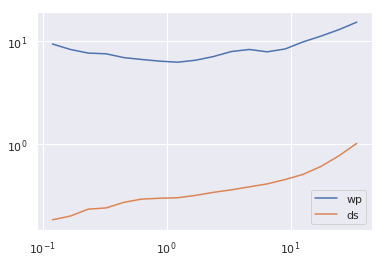

In [94]:
plt.plot(rp_points, rp_points*np.sqrt(np.diag(full_cov[:18, :18]) ), label = 'wp')
#plt.plot(rp_points, np.sqrt(np.diag(shape_noise_covmat) ), label = 'Shape')
#plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ), label = 'ds')
plt.plot(rp_points, rp_points*np.sqrt(np.diag(full_cov[18:36, 18:36]) ), label = 'ds')

plt.loglog()
plt.legend(loc='best')

In [95]:
print np.sqrt(np.diag(full_cov[:36][:,:36]))

[7.76342651e+01 4.92811538e+01 3.25762794e+01 2.29874934e+01
 1.51333047e+01 1.04075886e+01 7.18888869e+00 5.03565087e+00
 3.77559541e+00 2.94036425e+00 2.35766475e+00 1.76926487e+00
 1.20360634e+00 9.20662808e-01 7.72582034e-01 6.30990729e-01
 5.22016402e-01 4.43040771e-01 1.52715641e+00 1.19049197e+00
 9.96397312e-01 7.34656111e-01 5.96836050e-01 4.60430543e-01
 3.36125829e-01 2.43813755e-01 1.84249699e-01 1.41410422e-01
 1.07300410e-01 8.22089453e-02 6.29814218e-02 4.97808088e-02
 4.00279814e-02 3.42958831e-02 3.11503736e-02 2.95013596e-02]


In [96]:
print  np.sqrt(np.diag(full_cov[18:36, 18:36]) )

[1.52715641 1.19049197 0.99639731 0.73465611 0.59683605 0.46043054
 0.33612583 0.24381375 0.1842497  0.14141042 0.10730041 0.08220895
 0.06298142 0.04978081 0.04002798 0.03429588 0.03115037 0.02950136]


In [97]:
#emu covs
emu_cov_fnames = ['/home/users/swmclau2/Git/pearce/bin/optimization/wp_hod_emu_cov_lpw.npy',
                  '/home/users/swmclau2/Git/pearce/bin/optimization/ds_hod_emu_cov_lpw.npy']

In [98]:
emu_cov = np.zeros_like(full_cov[:36][:, :36])

for i, fname in enumerate(emu_cov_fnames):
    
    emu_cov[i*18:(i+1)*18][:, i*18:(i+1)*18] = np.load(fname)

In [99]:
emu_corr = cov_to_corr(emu_cov)

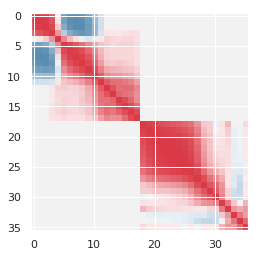

In [100]:
plt.imshow(emu_corr, cmap = cmap, vmin = -1)

In [101]:
full_emu_cov = full_cov[:36][:, :36] + emu_cov

In [102]:
print np.sqrt(np.diag(full_emu_cov[:36][:,:36]))

[7.07619919e+02 3.67130185e+02 1.50402773e+02 5.95041340e+01
 2.60452566e+01 2.44459357e+01 2.11211695e+01 1.40443359e+01
 8.07519351e+00 4.68086871e+00 2.99129327e+00 2.07400315e+00
 1.45453642e+00 1.17037012e+00 9.81732601e-01 8.33404044e-01
 7.11037106e-01 6.18712661e-01 2.24983909e+00 1.86350123e+00
 1.63190521e+00 1.31654640e+00 1.06154856e+00 8.03086962e-01
 5.60035478e-01 3.67028308e-01 2.39964663e-01 1.63311851e-01
 1.18208088e-01 8.85465400e-02 6.71263950e-02 5.24673566e-02
 4.25241300e-02 3.63812876e-02 3.43779394e-02 3.33100650e-02]


In [103]:
full_emu_corr = cov_to_corr(full_emu_cov)

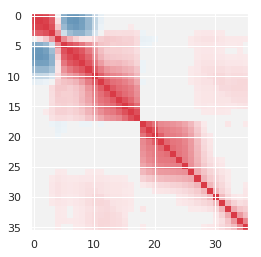

In [104]:
plt.imshow(full_emu_corr, cmap = cmap, vmin = -1)

In [105]:
mean[:,:18].mean(axis=0)

array([7407.57577016, 5860.73332887, 4562.57221101, 3528.4855154 ,
       2653.86635206, 1942.18765577, 1375.70010706,  920.94666884,
        574.1329663 ,  334.4338443 ,  189.53636194,  118.15514169,
         84.2912142 ,   62.74489775,   45.52641089,   31.41342237,
         20.19772416,   11.76164792])

In [106]:
np.sqrt(np.diag(full_emu_cov[:18, :18]) )/mean[:-1, :18].mean(axis=0)

array([0.17686479, 0.12449373, 0.07090224, 0.03944567, 0.02491593,
       0.03427243, 0.0437005 , 0.04326766, 0.03671197, 0.03039257,
       0.02655751, 0.02418775, 0.02211743, 0.02365729, 0.02733281,
       0.03363806, 0.04469265, 0.06731582])

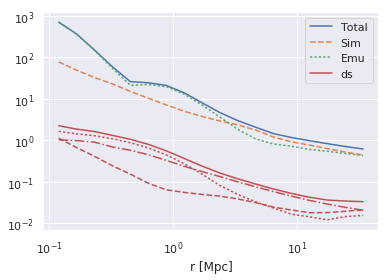

In [112]:
plt.plot(rp_points, np.sqrt(np.diag(full_emu_cov[:18, :18]) ), label = 'Total')
plt.plot(rp_points, np.sqrt(np.diag(cov[:18, :18]) ), ls = '--', label = 'Sim')
plt.plot(rp_points, np.sqrt(np.diag(emu_cov[:18, :18]) ), ls = ':', label = 'Emu')


plt.plot(rp_points, np.sqrt(np.diag(full_emu_cov[18:36, 18:36])) , label = 'ds', color ='r')
plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ),  color = 'r', ls = '--')
plt.plot(rp_points, np.sqrt(np.diag(emu_cov[18:36, 18:36]) ), color = 'r', ls = ':')
plt.plot(rp_points, np.sqrt(np.diag(shape_noise_covmat)), color = 'r',  ls = '-.')

#plt.ylabel('Delta Sigma Unc')
plt.xlabel('r [Mpc]')
plt.loglog()
plt.legend(loc='best')

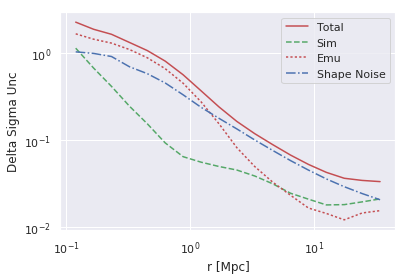

In [110]:
#plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ), label = 'ds')
plt.plot(rp_points, np.sqrt(np.diag(full_emu_cov[18:36, 18:36])) , label = 'Total', color ='r')
plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ),  color = 'g', label = 'Sim', ls = '--')
plt.plot(rp_points, np.sqrt(np.diag(emu_cov[18:36, 18:36]) ), color = 'r', ls = ':', label = 'Emu')
plt.plot(rp_points, np.sqrt(np.diag(shape_noise_covmat)), color = 'b', label = 'Shape Noise',ls = '-.')

plt.ylabel('Delta Sigma Unc')
plt.xlabel('r [Mpc]')
plt.loglog()
plt.legend(loc='best')

In [109]:
0.7**2

0.48999999999999994